In this notebook, I will try to use random forest from scikit-learn, to see if it can increase the recall of the score in the test set.

# Import required libraries

## For visualization

In [ ]:
import matplotlib.pyplot as plt

## For modelling

In [3]:
from sklearn.ensemble import RandomForestClassifier

## For Getting data from file to variable

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

## For evaluation and preprocessing

In [6]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Prepare data

In [1]:
!unzip data.zip

Archive:  data.zip
   creating: Dataset/
  inflating: Dataset/Train.csv       
  inflating: Dataset/sample_submission.csv  
  inflating: Dataset/Test.csv        


In [2]:
DATA_PATH = Path('/content/Dataset')

train_data = pd.read_csv(DATA_PATH/'Train.csv', index_col=0, infer_datetime_format=True, converters={'DATE':pd.to_datetime})
train_data.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
INCIDENT_ID,,,,,,,,,,,,,,,,,
CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


# Model setup

In [7]:
# since we may need the model to work on data with proper sequence
train_data.sort_values(by='DATE', inplace=True)

In [54]:
seed=1234
np.random.seed(seed=seed)

In [86]:
# form a pipeline with scaler and Randomforest classifier
pipe = Pipeline([
                 ('median_imputer', SimpleImputer(strategy='median')),
                 ('tree', RandomForestClassifier(
                     max_depth=5, class_weight='balanced_subsample',
                     min_samples_split=3,
                     max_features=None,
                     oob_score=True,
                     n_estimators=300,
                     random_state=seed))
                 ])

# Data Preprocessing

In [87]:
from sklearn.model_selection import train_test_split

# We will try not to use dates now
x_train, x_test, y_train, y_test = train_test_split(train_data.drop(['DATE', 'MULTIPLE_OFFENSE'], axis='columns'), 
                                                    train_data['MULTIPLE_OFFENSE'],
                                                    random_state=seed,
                                                    # Stratified split
                                                    stratify=train_data['MULTIPLE_OFFENSE'].values)

In [88]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17892, 15), (17892,), (5964, 15), (5964,))

In [89]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('median_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('tree',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced_subsample',
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
               

# Model Evaluation

In [90]:
pipe.score(x_test, y_test)

0.9723340040241448

In [91]:
y_pred = pipe.predict(x_test)

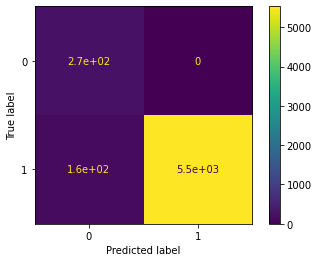

In [92]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, x_test, y_test)

In [93]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TP = {tp} \nFP = {fp}\nTN = {tn}\nFN = {fn}')

TP = 5532 
FP = 0
TN = 267
FN = 165


In [94]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.62      1.00      0.76       267
     class 1       1.00      0.97      0.99      5697

    accuracy                           0.97      5964
   macro avg       0.81      0.99      0.87      5964
weighted avg       0.98      0.97      0.98      5964



We can see that the model was able to predict all the cases where the server had encountered a malfunction, however we can see the value of `False Negative (FN)` is `165`, that is on those number of times the server wrongly flagged a problem when the server was actually working properly.

One should consider the **loss** of revenue on server malfunction and **cost** of dealing with false alarms from the model, for decision making regarding deployment. 

## Checking feature importances

In [98]:
forest = pipe['tree']

Feature ranking:
1. feature 9 (0.653665)
2. feature 14 (0.184375)
3. feature 10 (0.161383)
4. feature 5 (0.000213)
5. feature 11 (0.000104)
6. feature 12 (0.000093)
7. feature 13 (0.000043)
8. feature 6 (0.000034)
9. feature 3 (0.000030)
10. feature 1 (0.000028)
11. feature 2 (0.000021)
12. feature 4 (0.000004)
13. feature 8 (0.000002)
14. feature 7 (0.000002)
15. feature 0 (0.000000)


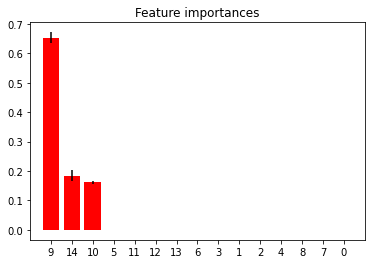

In [101]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

Only three features where informative, those must be `X_9`, `X_14` and `X_10`

# Test data Prediction

In [102]:
test_data = pd.read_csv(DATA_PATH/'Test.csv', index_col=0)
test_data.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
INCIDENT_ID,,,,,,,,,,,,,,,,
CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [103]:
test_data.drop('DATE', axis='columns', inplace=True)

In [104]:
y_pred = pipe.predict(test_data)

In [105]:
sub_df = pd.DataFrame(
    {'INCIDENT_ID':test_data.index,
     'MULTIPLE_OFFENSE':y_pred},
     )
sub_df.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [106]:
sub_df.to_csv('submission_rf.csv', index=False)

This submission scored a decent `85` (recall) on the test set, but it can be improved further.

# Model Persistence

In [110]:
!pip list | egrep 'scikit-learn|pandas'

matplotlib               3.2.1          
matplotlib-venn          0.11.5         
pandas                   1.0.4          
pandas-datareader        0.8.1          
pandas-gbq               0.11.0         
pandas-profiling         1.4.1          
scikit-learn             0.22.2.post1   
sklearn-pandas           1.8.0          


In [111]:
import joblib

with open('rf_pipeline.joblib', 'wb') as f:joblib.dump(pipe, f)

In [112]:
!zip rf_model_archive.zip submission_rf.csv rf_pipeline.joblib

  adding: submission_rf.csv (deflated 70%)
  adding: rf_pipeline.joblib (deflated 72%)
